# Plain vs. Skip Deep Decoder

In [1]:
from __future__ import print_function
import matplotlib.pyplot as plt
#%matplotlib notebook

import os

import warnings
warnings.filterwarnings('ignore')

from include import *
from PIL import Image
import PIL

import numpy as np
import torch
import torch.optim
from torch.autograd import Variable

GPU = True
if GPU == True:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    dtype = torch.cuda.FloatTensor
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    print("num GPUs",torch.cuda.device_count())
else:
    dtype = torch.FloatTensor

num GPUs 1


In [2]:
def myimgshow(plt,img):
    plt.gray()
    plt.rcParams["figure.figsize"] = (6,6)
    plt.imshow(np.clip(img[0],0,1),interpolation='nearest')

## Load image

In [3]:
path = './test_data/'
#img_name = "phantom256"
img_name = "brain_sagittal.jpg"
img_path = path + img_name #+ ".png"
img_pil = Image.open(img_path)
img_np = np.array([pil_to_np(img_pil)[0]])
img_np = img_np / np.max(img_np)
img_var = np_to_var(img_np).type(dtype)

In [4]:
img_np.shape,img_var.shape

((1, 256, 256), torch.Size([1, 1, 256, 256]))

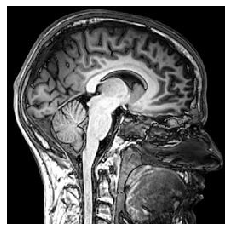

In [5]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

## Define network ant train it

In [7]:
skip_psnr = []
skip_params = []
plain_psnr = []
plain_params = []
output_depth = img_np.shape[0]
num_channels = 64
rnd = 500
numit = 10000
rn = 0.001
maxv = np.max(img_np)
in_size = [32,32]
out_size = img_np[0].shape
for num_layers in [4]:
    
    skipnet = skipdecoder(out_size,in_size,output_depth,num_layers,num_channels,skips=True).type(dtype)
    skip_params.append(num_param(skipnet))
    
    plainnet = skipdecoder(out_size,in_size,output_depth,num_layers,num_channels,skips=False).type(dtype)
    plain_params.append(num_param(plainnet))
    
    print("#layers:",num_layers)
    print("train skip") 
    mse_n, mse_t, skipni, skipnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=0.01,
                            img_noisy_var=img_var,
                            net=skipnet,
                            img_clean_var=img_var,
                            find_best=True,
                            )
    out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
    skip_psnr.append(psnr(img_np,out_img_np,maxv))
    print("\n")
    
    print("train plain")    
    mse_n, mse_t, plainni, plainnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=0.01,
                            img_noisy_var=img_var,
                            net=plainnet,
                            net_input = skipni ,
                            img_clean_var=img_var,
                            find_best=True,
                            #orth_reg=0.1,
                            )    
    out_img_np = plainnet( plainni.type(dtype) ).data.cpu().numpy()[0]
    plain_psnr.append(psnr(img_np,out_img_np,maxv)) 
    print("\n")

#layers: 4
train skip
shape:  [1, 64, 32, 32]
optimize with adam 0.01
Iteration 09990    Train loss 0.002379  Actual loss 0.002379 Actual loss orig 0.002379  Noise Energy 0.000000 

train plain
input provided
optimize with adam 0.01


KeyboardInterrupt: 

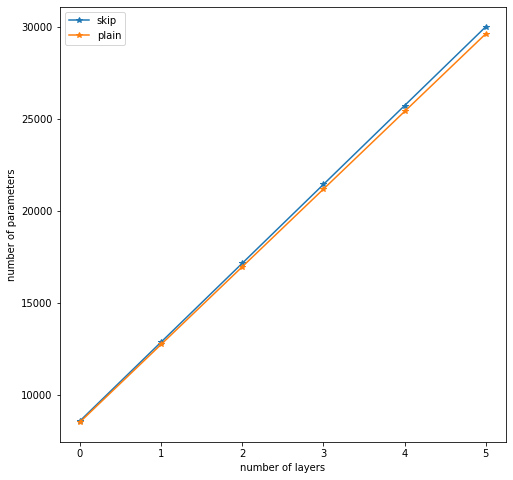

In [12]:
plt.plot(skip_params,"-*",label="skip")
plt.plot(plain_params,"-*",label="plain")
plt.xlabel("number of layers")
plt.ylabel("number of parameters")
plt.legend()
plt.show()

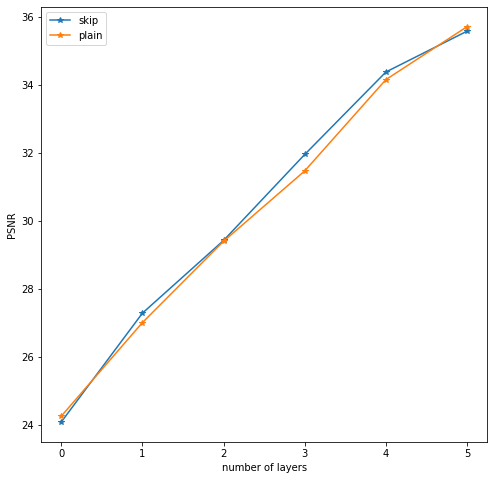

In [13]:
plt.plot(skip_psnr,"-*",label="skip")
plt.plot(plain_psnr,"-*",label="plain")
plt.xlabel("number of layers")
plt.ylabel("PSNR")
plt.legend()
plt.show()

### Visualize Skipnet Activations and Output (for the last setup (last number of layers (8)))

##### skip deep decoder representation for the input image

Skip-Deep-Decoder representation of the image, SNR: 26.645109104093933


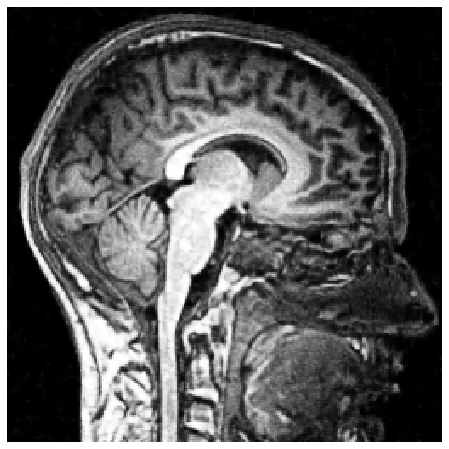

In [8]:
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
maxv = np.max(img_np)
print("Skip-Deep-Decoder representation of the image, SNR: " + str(psnr(img_np,out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.show()

In [3]:
def apply_until(net_input,net,n = 100):
    # gets intermediate outputs from the network
    if n == 0:
        return net_input
    else:
        print("output up to block{}: {}".format(n,net[n-1]))
        return net[:n](net_input.type(dtype))

def plot_tensor(out,nrows=1):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

##### individual channels per layer

output up to block4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


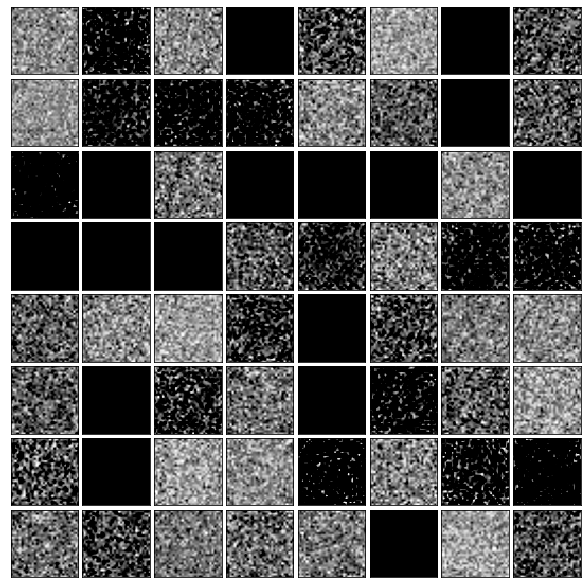

output up to block8: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


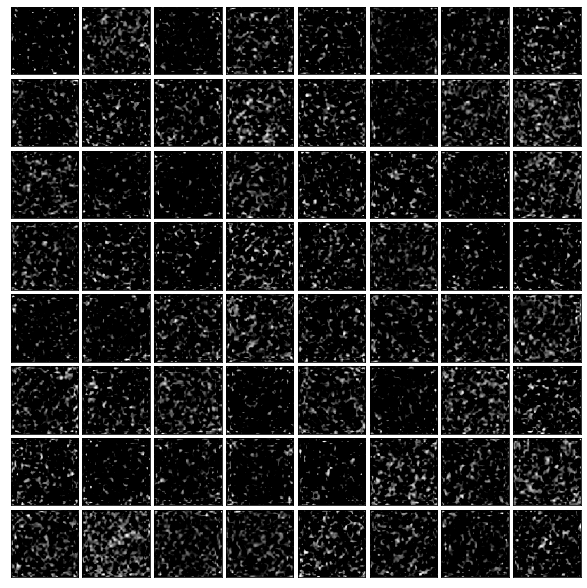

output up to block12: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


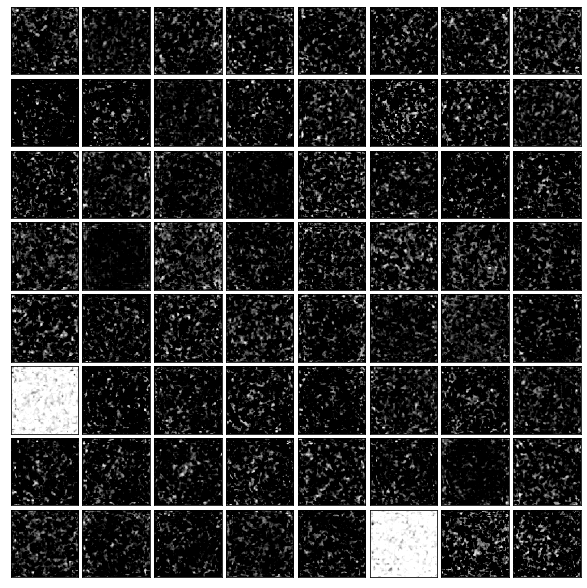

In [10]:
intermed_layers = skipnet.layer_inds + [skipnet.layer_inds[-1]+(skipnet.layer_inds[-1]-skipnet.layer_inds[-2])] # concat the index of the last layer before the combining layer manually

for n in intermed_layers:
        out = apply_until(skipni,skipnet.net1,n)
        plot_tensor(out)

##### mean over channels per layer

layer4
output up to block4: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


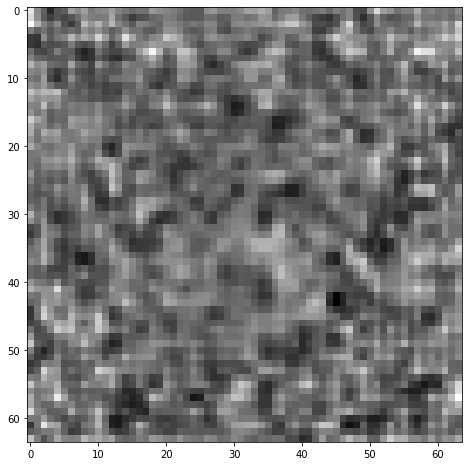

layer8
output up to block8: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


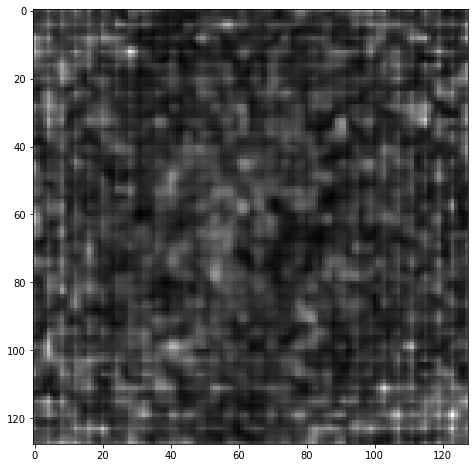

layer12
output up to block12: BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


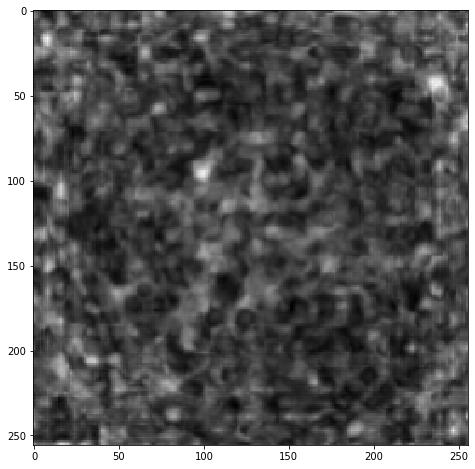

In [11]:
for n in intermed_layers:
    print("layer{}".format(n))
    out = apply_until(skipni,skipnet.net1,n)
    plt.imshow(out.mean(1)[0].data.cpu())
    plt.show()

##### original image

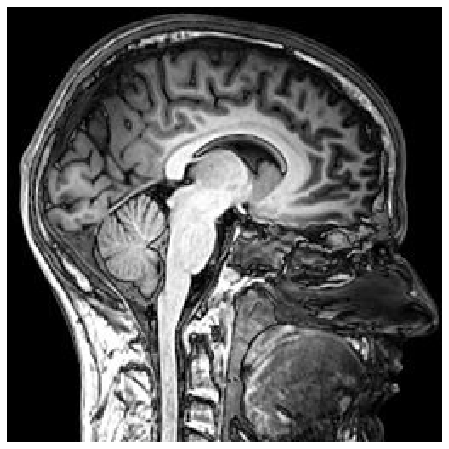

In [16]:
myimgshow(plt,img_np)
plt.axis('off')
#plt.savefig('exp_vis_sub'+img_name+'_final.png')
plt.show()

# Draft

In [3]:
def apply_until(net_input,net,n = 100):
    # gets intermediate outputs from the network
    if n == 0:
        return net_input
    else:
        print("output up to block{}: {}".format(n,net[n-1]))
        return net[:n](net_input.type(dtype))

def plot_tensor(out,nrows=1):
    imgs = [img for img in out.data.cpu().numpy()[0]]
    fig = plot_image_grid(imgs,nrows=nrows)
    plt.show()

### simple test

##### generate a random image

shape:  [1, 1, 16, 16]


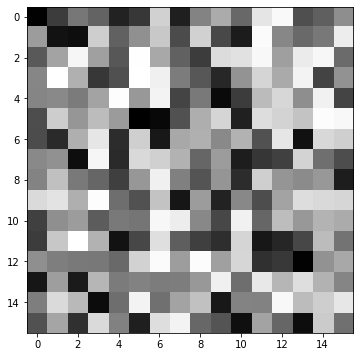

In [23]:
in_size = [4,4] # size of network input
num_channels = 6 # number of input channels (and also number of channels per layer)
out_size = [16,16] # size of original image
output_depth = 1 # number of channels in the original image
num_layers = 4

width = out_size[0]
height = out_size[1]
shape = [1,output_depth, width, height]
print("shape: ", shape)
img_var = Variable(torch.zeros(shape))
img_var.data.uniform_()
img_var.data *= 1./10
img_var = img_var.type(dtype)

myimgshow(plt,img_var[0].cpu())

##### create a skip network

In [24]:
skipnet = skipdecoder(out_size,in_size,output_depth,num_layers,num_channels,skips=True).type(dtype)
print("number of skipnet params:", num_param(skipnet))

number of skipnet params: 162


In [25]:
skipnet

skip_model(
  (act_fun): ReLU()
  (sig): Sigmoid()
  (net1): Sequential(
    (1): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Upsample(size=(7, 7), mode=bilinear)
    (3): ReLU()
    (4): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (6): Upsample(size=(11, 11), mode=bilinear)
    (7): ReLU()
    (8): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(6, 6, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (10): Upsample(size=[16, 16], mode=bilinear)
    (11): ReLU()
    (12): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (net2): Sequential(
    (1): Conv2d(18, 1, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): Sigmoid()
  )
)

##### fit the skipnet to the original image

In [26]:
rnd = 500
numit = 10000
rn = 0.001
maxv = np.max(np.array(img_var[0].cpu()))
mse_n, mse_t, skipni, skipnet = fit( in_size = in_size,
                            num_channels=[num_channels]*(num_layers-1),
                            reg_noise_std=rn,
                            reg_noise_decayevery = rnd,
                            num_iter=numit,
                            LR=1e-2,
                            img_noisy_var=img_var,
                            net=skipnet,
                            img_clean_var=img_var,
                            find_best=True,
                            )
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]

shape:  [1, 6, 4, 4]
optimize with adam 0.01


##### individual channels per layer (before and after upsampling)

output up to block4: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


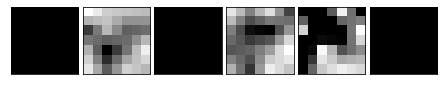

its upsampled version before feeding to the last layer


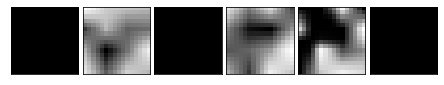



output up to block8: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


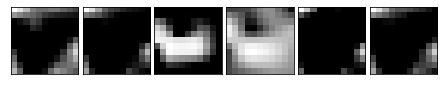

its upsampled version before feeding to the last layer


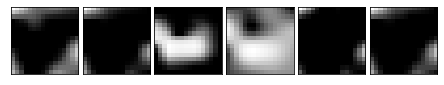



output up to block12: BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


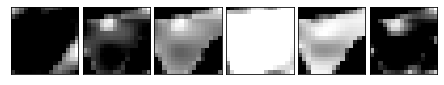

In [28]:
intermed_layers = skipnet.layer_inds + [skipnet.layer_inds[-1]+4] # concat the index of the last layer before the combining layer manually
intermed_upsampled = [skipnet.combinations[:,num_channels*i:num_channels*(i+1),:,:] for i in range(num_layers-1)] # this contains inputs of the last layer (i.e., upsampled versions of previous layers' outputs)
for i,n in enumerate(intermed_layers):
        out = apply_until(skipni,skipnet.net1,n)
        plot_tensor(out)
        if n != intermed_layers[-1]:
            print("its upsampled version before feeding to the last layer")
            plot_tensor(intermed_upsampled[i])
        print('\n')

##### skipnet representation ofthe image

Skip-Deep-Decoder representation of the image, SNR: 13.178064812913737


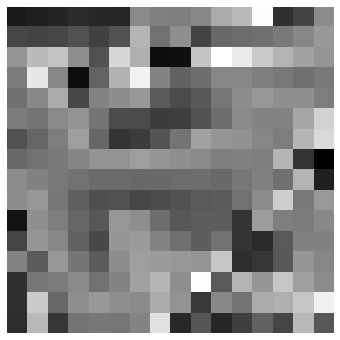

In [27]:
out_img_np = skipnet( skipni.type(dtype) ).data.cpu().numpy()[0]
print("Skip-Deep-Decoder representation of the image, SNR: " + str(psnr(img_var[0].data.cpu().numpy(),out_img_np,maxv)))
myimgshow(plt,out_img_np)
plt.axis('off')
plt.show()

##### original image

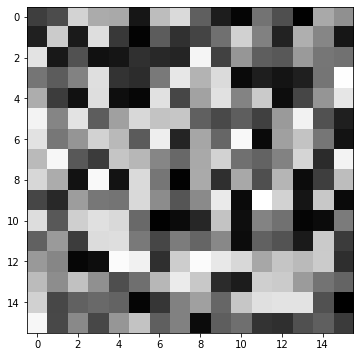

In [12]:
myimgshow(plt,img_var[0].cpu())